In [1]:
import DifferentialEquations as DE
import ModelingToolkit as MTK
import Plots
import ModelingToolkit: t_nounits as t, D_nounits as D, @variables, @parameters, @named, @mtkbuild, @register_symbolic

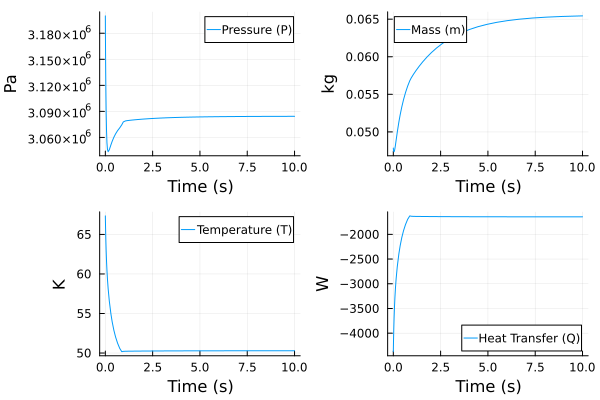

In [ ]:
# Q9. MTK ver
using CoolProp, ModelingToolkit, DifferentialEquations
# CoolProp 함수들을 MTK에 등록합니다. (추후 Tabular 값으로 변경)
 # ρ, T 등을 P, h에서 계산하는 함수
R410a_density(p, h) = PropsSI("Dmass", "P", p, "Hmass", h, "R410A")
R410a_temperature(p, h) = PropsSI("T", "P", p, "Hmass", h, "R410A")

@register_symbolic R410a_density(p, h) 
@register_symbolic R410a_temperature(p, h)

Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{1}) = R410a_density(args[1]+1, args[2]) -  R410a_density(args[1], args[2])
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{2}) = R410a_density(args[1], args[2]+1) -  R410a_density(args[1], args[2])

function CV_1_problem()
    
    @parameters V = 0.02*0.02 T_wall = 40 + 273.15 UA = 8000 * 0.02
    @parameters c1 = 9 * 1e-6 c2 = 9 * 1e-6
    @parameters P_in = 3200e3 P_out = 3000e3 h_in = 450e3 ρ_in = R410a_density(P_in, h_in)
    @variables P(t)=P_in h(t)=h_in ρ(t) T(t)
    @variables mdot_in(t) mdot_out(t) Q(t) h_out(t)

    eqs = [
        # Algebraic eqns
        ρ ~ R410a_density(P, h),
        T ~ R410a_temperature(P, h),
        mdot_in ~ c1 * sqrt(max(0.0, ρ_in * (P_in - P))),
        mdot_out ~ c2 * sqrt(max(0.0, ρ * (P - P_out))),
        h_out ~ h,
        Q ~ UA * (T_wall - T),
        
        # Differential eqns
        V * D(ρ) ~ mdot_in - mdot_out,
        V*h*D(ρ) + V*ρ*D(h) - V*D(P) ~ mdot_in*h_in - mdot_out*h_out + Q
    ]
    @mtkbuild sys = MTK.ODESystem(eqs, t)
    return sys
end

function solve_CV_1_problem(;tspan = (0.0, 10.0))
    # Convert from a symbolic to a numerical problem to simulate
    sys = CV_1_problem()
    prob = DE.ODEProblem(sys, [], tspan)
    # Solve the ODE
    return DE.solve(prob, Rodas5P(autodiff=false))
end

function plot_the_res(sol, P_sol, h_sol)
    V = 0.02 * 0.02  # Volume
    UA = 8000 * 0.02  # Overall heat transfer coefficient
    T_wall = 40  # Wall temperature in Celsius
    m_sol = R410a_density.(P_sol, h_sol) .* V
    T_sol = R410a_temperature.(P_sol, h_sol) .- 273.15
    Q_sol = UA .* (T_wall .- T_sol)

    # Plot the solution
    p1 = Plots.plot(sol.t, P_sol, label="Pressure (P)", xlabel="Time (s)", ylabel="Pa")
    p2 = Plots.plot(sol.t, m_sol, label="Mass (m)", xlabel="Time (s)", ylabel="kg")
    p3 = Plots.plot(sol.t, T_sol, label="Temperature (T)", xlabel="Time (s)", ylabel="K")
    p4 = Plots.plot(sol.t, Q_sol, label="Heat Transfer (Q)", xlabel="Time (s)", ylabel="W")
    return Plots.plot(p1, p2, p3, p4, layout = (2, 2))
end

sol = solve_CV_1_problem(tspan = (0.0, 10.0))
plot_the_res(sol, sol[1, :], sol[3, :])
